In [44]:
# Imports
import numpy as np
import pygad
import pygad.kerasga

from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
# Load the iris dataset.
iris = load_iris()
X: np.ndarray = iris.data
y: np.ndarray = iris.target

In [17]:
# Categorize the labels.
y = to_categorical(y)

In [18]:
# Split the dataset into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Scale the data.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# Create the Keras model.
def create_model(input_dim: int, num_classes: int) -> Sequential:
    global model
    model = Sequential(
        [
            Dense(10, input_dim=input_dim, activation='relu'),
            Dense(num_classes, activation='softmax')
        ]
    )
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

In [22]:
# Define the fitness function for classification.
def fitness_func(_ga_instance: pygad.GA, sol: np.ndarray, _sol_idx: int) -> float:
    global X_train, y_train, keras_ga, model
    preds = pygad.kerasga.predict(model=model,
                                  solution=sol,
                                  data=X_train)
    # Compute the classification accuracy
    preds_class = np.argmax(preds, axis=1)
    y_train_class = np.argmax(y_train, axis=1)
    accuracy = np.mean(preds_class == y_train_class)
    # Return the classification accuracy as the fitness value.
    return accuracy

In [26]:
# Define the callback function.
def on_generation(ga: pygad.GA) -> None:
    print(f'Generation: {ga.generations_completed}')
    print(f'Fitness: {ga.best_solution()[1]}')

In [23]:
# Define the parameters.
num_inputs = X_train.shape[1]
num_outputs = y_train.shape[1]
sol_per_pop = 10
num_generations = 50

In [27]:
# Create the model.
model = create_model(num_inputs, num_outputs)
keras_ga = pygad.kerasga.KerasGA(
    model=model,
    num_solutions=sol_per_pop,
)

2023-04-14 17:27:04.465536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-14 17:27:05.009891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-14 17:27:05.009958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-14 17:27:05.017609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-14 17:27:05.017722: I tensorflow/compile

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Some parameters are initialized within the constructor.
initial_population = keras_ga.population_weights

In [35]:
# Create an instance of the GA class inside the ga module.
ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=sol_per_pop // 2,
    initial_population=initial_population,
    fitness_func=fitness_func,
    on_generation=on_generation,
)

In [36]:
# Run the genetic algorithm.
ga_instance.run()

4/4 [==============================] - 8s 3ms/step


2023-04-14 17:30:11.478558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4/4 [==============================] - 0s 2ms/step
Generation: 1
4/4 [==============================] - 0s 2ms/step
Fitness: 0.6833333333333333
4/4 [==============================] - 0s 2ms/step
Generation: 2
4/4 [==============================] - 0s 2ms/step
Fitness: 0.6833333333333333
4/4 [==============================] - 0s 2ms/step
Generation: 3
4/4 [==============================] - 0s 2ms/step
Fitness: 0.6833333333333333
4/4 [==============================] - 0s 2ms/step
Generation: 4
4/4 [==============================] - 0s 2ms/step
Fitness: 0.6833333333333333
4/4 [==============================] - 0s 2ms/step
Generation: 5
4/4 [==============================] - 0s 2ms/step
Fitness: 0.7333333333333333
4/4 [==============================] - 0s 2ms/step
Generation: 6
4/4 [==============================] - 0s 2ms/step
Fitness: 0.7333333333333333
4/4 [==============================] - 0s 2ms/step
Generation: 7
4/4 [==============================] - 0s 2ms/step
Fitness: 0.741666666

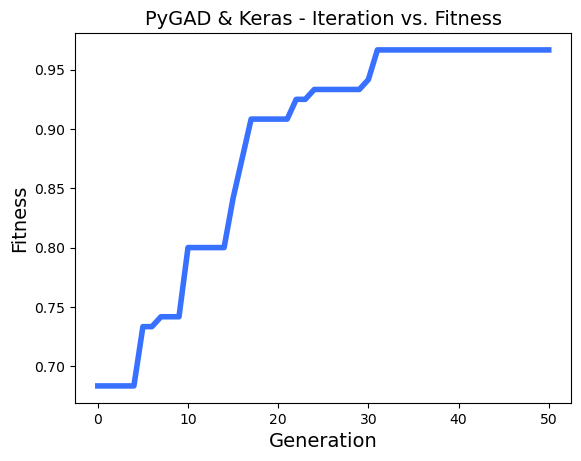

In [43]:
# After the generations complete, some plots are shown that summarize
# how the outputs/fitness values evolve over generations.
_ = ga_instance.plot_fitness(
    title="PyGAD & Keras - Iteration vs. Fitness",
    linewidth=4
)

In [42]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Fitness value of the best solution = {solution_fitness}")
print(f"Index of the best solution : {solution_idx}")

4/4 [==============================] - 0s 2ms/step
Fitness value of the best solution = 0.9666666666666667
Index of the best solution : 0


In [54]:
# Make prediction based on the best solution.
predictions = pygad.kerasga.predict(
    model=model,
    solution=solution,
    data=X_test
)
# Get the updated weights from the solution array.
updated_weights = pygad.kerasga.model_weights_as_matrix(
    model=model,
    weights_vector=solution
)
# Set the updated weights in the original model.
model.set_weights(updated_weights)
# Evaluate the model on the test data to get the loss and any other metrics.
loss, precision = model.evaluate(X_test, y_test)
print(f"Precision: {precision:.2%}")
print(f"Loss: {loss:.5f}")

1/1 [==============================] - 0s 36ms/step - loss: 0.0906 - accuracy: 0.9667
Precision: 96.67%
Loss: 0.09059
